In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Overview of Train_Dataset

In [3]:
def optimize_column(df):
    for column in df.select_dtypes(include = ['int64', 'float64']).columns:
        df[column] = pd.to_numeric(df[column],downcast = 'integer')
    return df

First Few Rows of the Dataset:
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0   180388628218      0         612   123247  2024-06-04T06:05:15.000Z   
1   455266534868     88         326   210035  2024-06-14T03:01:25.000Z   
2  1056561957389    809       58352   712507  2024-06-13T04:52:55.000Z   
3  1279900258736     92       32992   774301  2024-06-10T16:39:36.000Z   
4   214748368522    148        4359   188041  2024-06-15T01:08:07.000Z   

   DetectorId  AlertTitle           Category MitreTechniques   IncidentGrade  \
0           7           6      InitialAccess             NaN    TruePositive   
1          58          43       Exfiltration             NaN   FalsePositive   
2         423         298      InitialAccess           T1189   FalsePositive   
3           2           2  CommandAndControl             NaN  BenignPositive   
4           9          74          Execution             NaN    TruePositive   

   ... ResourceType Roles OSFamily OSVersio

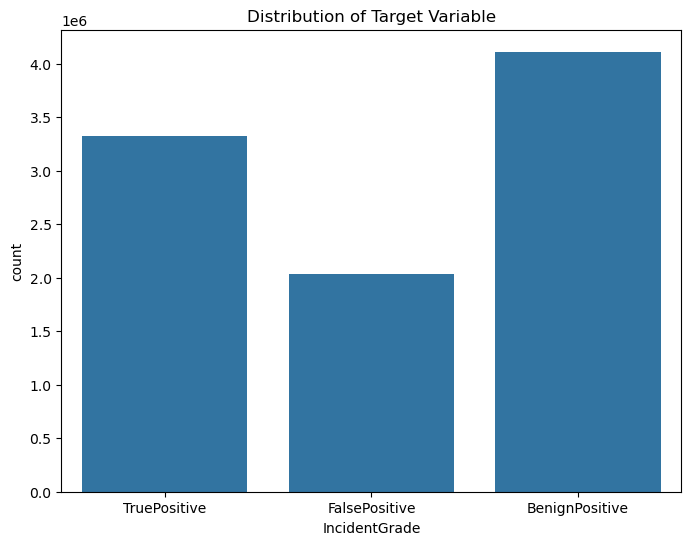

In [23]:
chunks = []

# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(r"GUIDE_Train.csv", chunksize=500000,low_memory=False):
    chunk = optimize_column(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

# First five rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# shape of the dataset
print("\nShape of the dataset:", df.shape)

# Column names
print("Column Names in the Dataset:")
print(df.columns)

print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())

# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

# Data Cleaning and Preprocessing(Train Dataset)

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



# Read data in chunks and concatenate
chunks = pd.read_csv(r"GUIDE_Train.csv", chunksize=500000, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values and dropped:")
print(columns_to_drop)

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5) 

# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


# Drop the 'Timestamp' column
df.drop(columns=['Timestamp'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

columns_to_encode = ['State', 'City', 'OSVersion', 'CountryCode']
df[columns_to_encode] = df[columns_to_encode].astype(str)
df = pd.get_dummies(df, columns=columns_to_encode)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save 
df.to_csv("Train_dataset.csv", index=False)
print("Data preprocessing complete and saved .")

Columns with more than 50% missing values and dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')
Imputed categorical column 'IncidentGrade' with mode value: BenignPositive
Data preprocessing complete and saved .


# Overview of Test_Dataset

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
def optimize_column(df):
    for column in df.select_dtypes(include = ['int64', 'float64']).columns:
        df[column] = pd.to_numeric(df[column],downcast = 'integer')
    return df

First Few Rows of the Dataset:
              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0  1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1  1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2  1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3    60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4   515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   

   DetectorId  AlertTitle           Category                  MitreTechniques  \
0         524         563    LateralMovement      T1021;T1047;T1105;T1569.002   
1           2           2  CommandAndControl                              NaN   
2        2932       10807    LateralMovement  T1021;T1027.002;T1027.005;T1105   
3           0           0      InitialAccess                  T1078;T1078.004   
4          27          18          Discovery                  T1087;T1087.002   

    IncidentGrade  ...       Roles OS

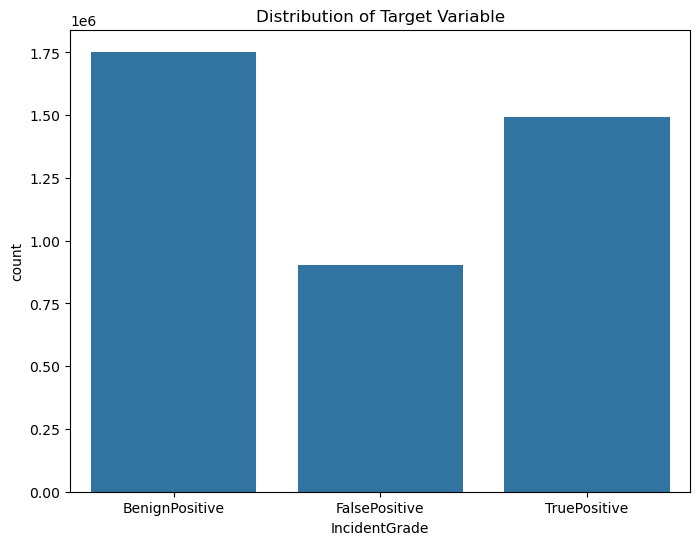

In [30]:
chunks = []

# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(r"GUIDE_Test.csv", chunksize=500000,low_memory=False):
    chunk = optimize_column(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

# First five rows of the dataset
print("First Few Rows of the Dataset:")
print(df.head())

# shape of the dataset
print("\nShape of the dataset:", df.shape)

# Column names
print("Column Names in the Dataset:")
print(df.columns)

print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df['IncidentGrade'].value_counts())

# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [31]:
# Data Cleaning and Preprocessing(Test Dataset)

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Read data in chunks and concatenate
chunks = pd.read_csv(r"GUIDE_Train.csv", chunksize=500000, low_memory=False)
df = pd.concat(chunks, ignore_index=True)

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values and dropped:")
print(columns_to_drop)

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5) 

# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


# Drop the 'Timestamp' column
df.drop(columns=['Timestamp'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

columns_to_encode = ['State', 'City', 'OSVersion', 'CountryCode']
df[columns_to_encode] = df[columns_to_encode].astype(str)
df = pd.get_dummies(df, columns=columns_to_encode)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save 
df.to_csv("Test_dataset.csv", index=False)
print("Data preprocessing complete and saved")

Columns with more than 50% missing values and dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')
Imputed categorical column 'IncidentGrade' with mode value: BenignPositive
Data preprocessing complete and saved


# Training & Modelling

In [34]:
# Logistic Regression

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset     
df = pd.read_csv("Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)  
y = df['IncidentGrade']  

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,
                                                           stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)

# Initialize logistic regression
logreg = LogisticRegression(solver='liblinear')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Perform GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_logreg.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64     11720
           1       0.81      0.57      0.67     13464
           2       0.94      0.97      0.96    126942

    accuracy                           0.91    152126
   macro avg       0.80      0.73      0.76    152126
weighted avg       0.91      0.91      0.91    152126

Confusion Matrix:
[[  7707   1120   2893]
 [  1392   7632   4440]
 [  3080    639 123223]]


# Decision Tree Model

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Load the dataset
df = pd.read_csv("Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'criterion': ['gini', 'entropy'],  # Measure for quality of split
    'splitter': ['best', 'random'],  # The strategy used to choose the split at each node
    'max_depth': [5, 10, 20, 30, 50],  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dtree, param_distributions=param_distributions, 
                                   n_iter=100, scoring='accuracy', cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

# Perform RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best model from RandomizedSearchCV
best_dtree = random_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_dtree.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
195 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
128 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\dilib\anaconda3\Lib\site-packag

Best Parameters:
{'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83     11720
           1       0.89      0.89      0.89     13464
           2       0.99      0.98      0.99    126942

    accuracy                           0.96    152126
   macro avg       0.89      0.91      0.90    152126
weighted avg       0.97      0.96      0.97    152126

Confusion Matrix:
[[ 10072    793    855]
 [   944  12016    504]
 [  1634    630 124678]]


# Random Forest Model

In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# Load dataset
df = pd.read_csv("Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20,30],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2',None],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Set up StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with StratifiedKFold cross-validation
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                      n_iter=20, scoring='f1_macro', cv=cv,
                                      n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model
random_search_rf.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Evaluate the best model on validation data
y_pred = best_rf.predict(X_val)

# Print results
print("Best Parameters:")
print(random_search_rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Best Parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11720
           1       0.97      0.98      0.97     13464
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.98      0.98      0.98    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11415    217     88]
 [   182  13140    142]
 [   116    173 126653]]


# Gradient Boosting Machines - XGBoost

In [41]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Load dataset
df = pd.read_csv("Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create a custom fit method with early stopping using partial
fit_with_early_stopping = partial(
    xgb_model.fit,
    early_stopping_rounds=10,         
    eval_set=[(X_val, y_val)],        
    verbose=0                        
)


xgb_model.fit = fit_with_early_stopping

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate (eta)
    'max_depth': [3, 6, 9],  # Maximum depth of each tree
    'subsample': [0.7, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
}

# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with the custom fit method
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of iterations to sample from param_distributions
    scoring='f1_macro',   # Use F1 macro as the scoring metric
    cv=cv,  # StratifiedKFold for cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV with early stopping
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_xgb = random_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_xgb.predict(X_val)

# Print the best parameters and evaluation results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\dilib\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     11720
           1       0.96      0.97      0.96     13464
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.97      0.97      0.97    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11118    344    258]
 [   280  13001    183]
 [   404    206 126332]]


In [43]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.97,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.91, 0.98, 0.97],
    'Precision': [0.80,0.90,0.98,0.97],
    'Recall': [0.73 ,0.92 ,0.98 ,0.97]

}

# Convert to DataFrame
df = pd.DataFrame(report)

df.to_csv('Comparison Table.csv',index=False)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

best_model.to_csv('Best_Model.csv')
# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.97            0.91       0.90    0.92
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.97       0.97    0.97

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from scipy.stats import randint

# Load dataset
df = pd.read_csv("Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50,75,100],  # Number of trees in the forest
    'max_depth': [10,15, 20,25],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Set up StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with StratifiedKFold cross-validation
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                      n_iter=10, scoring='f1_macro', cv=cv,
                                      n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model 
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Evaluate the best model on validation data
y_pred = best_rf.predict(X_val)

# Print results
print("Best Parameters:")
print(random_search_rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Save the best model to a pickle file

from joblib import dump

# Save the model directly by specifying the file path
dump(best_rf, "best_random_forest_model.joblib")
print("Model saved to best_random_forest_model.joblib")


Best Parameters:
{'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86     11720
           1       0.93      0.94      0.93     13464
           2       1.00      0.98      0.99    126942

    accuracy                           0.97    152126
   macro avg       0.90      0.96      0.93    152126
weighted avg       0.98      0.97      0.97    152126

Confusion Matrix:
[[ 11103    586     31]
 [   669  12671    124]
 [  2305    439 124198]]
Model saved to best_random_forest_model.joblib


# Feature Importance and Error Analysis

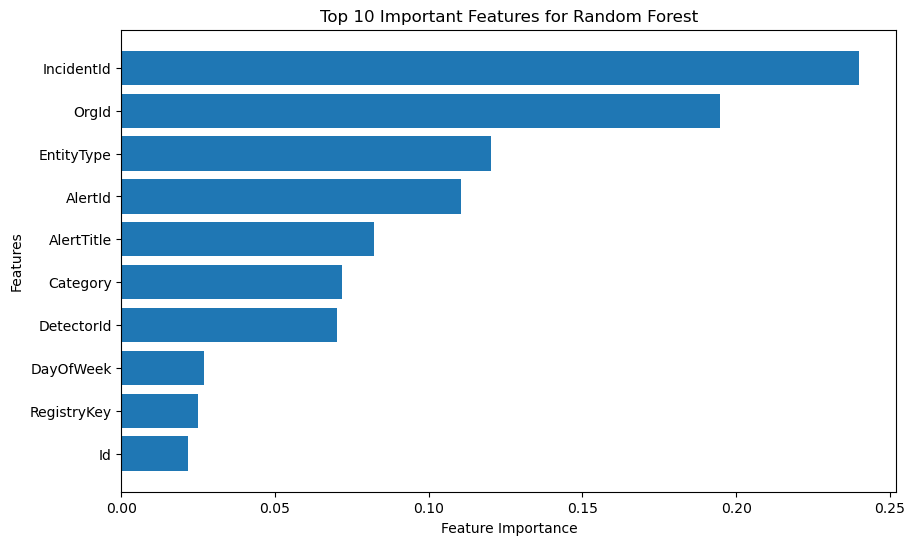

                   Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
416218  1236950582027    350       35994   239468           1    0.002278   
219464   627065228019    205       57298   159429           1    0.002278   
546508   670014900299    221       49462   448805           6    0.011390   
257149  1614907706641    211       80112   120272           6    0.011390   
117524  1082331761170    390      102949    94835          66    0.109339   

        Category  EntityType  EvidenceRole  DeviceId  ...  ResourceIdName  \
416218         5           5             1     98799  ...            3586   
219464         5           5             1     98799  ...            3586   
546508         5           5             1     98799  ...            3586   
257149         5           5             1     98799  ...            3586   
117524         5           5             1     98799  ...            3586   

        OSFamily  Year     Month  DayOfWeek      Hour  State_0.0  City_0.0

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = best_rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Evaluation of Selected Random Forest Model on Test Data

In [7]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Load the saved Random Forest model

best_rf = load("best_random_forest_model.joblib")

# Load the test dataset
test_data_path = "Test_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)  
y_test = test_df['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     58601
           1       0.95      0.96      0.96     67320
           2       1.00      0.98      0.99    634706

    accuracy                           0.98    760627
   macro avg       0.93      0.97      0.95    760627
weighted avg       0.98      0.98      0.98    760627


Macro-F1 Score: 0.95
Macro Precision: 0.93
Macro Recall: 0.97

Confusion Matrix on Test Data:
[[ 57068   1495     38]
 [  2260  64905    155]
 [  9707   1608 623391]]
